In [1]:
pip install MetaTrader5 pandas mplfinance seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import MetaTrader5 as mt
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

### MT5 Initialize

In [3]:
mt.initialize()

True

### Import data from MT5

In [4]:
symbol = "XAUUSD" #gold
timeframe = mt.TIMEFRAME_M5 #4 hours
utc_from = pd.Timestamp('2024-05-09') #start date
utc_to = pd.Timestamp.now() 

### Import to DataFrame

In [5]:
# Retrieve the data
rates = mt.copy_rates_range(symbol, timeframe, utc_from, utc_to)
df = pd.DataFrame(rates)
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
5308,1717588800,2332.79,2333.44,2332.15,2332.48,336,5,0
5309,1717589100,2332.50,2333.08,2331.97,2332.52,382,5,0
5310,1717589400,2332.44,2332.62,2331.07,2332.36,367,5,0
5311,1717589700,2332.40,2333.12,2332.24,2333.09,298,5,0
5312,1717590000,2333.08,2333.20,2332.67,2332.67,38,5,0


In [6]:
df = df.drop(['tick_volume','spread','real_volume'],axis=1)

In [7]:
df.info() # Check data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    5313 non-null   int64  
 1   open    5313 non-null   float64
 2   high    5313 non-null   float64
 3   low     5313 non-null   float64
 4   close   5313 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 207.7 KB


In [8]:
df.describe()

,time,open,high,low,close
count,5.313000e+03,5313.00000,5313.000000,5313.000000,5313.000000
mean,1.716409e+09,2360.79090,2361.640770,2359.919528,2360.790749
std,6.899547e+05,32.09864,32.183307,31.991424,32.091454
min,1.715217e+09,2307.49000,2308.030000,2306.730000,2307.510000
25%,1.715805e+09,2338.06000,2338.850000,2337.350000,2338.060000
50%,1.716397e+09,2350.57000,2351.230000,2349.810000,2350.580000
75%,1.716998e+09,2379.21000,2379.810000,2378.570000,2379.200000
max,1.717590e+09,2449.83000,2450.070000,2447.740000,2449.800000


In [9]:
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.rename(columns={'time': 'date/time'})
df.set_index('date/time', inplace=True)

In [167]:
# Display the first few rows of the DataFrame
df.head()

,open,high,low,close
date/time,,,,
2024-05-09 01:05:00,2309.55,2310.37,2309.39,2310.16
2024-05-09 01:10:00,2310.01,2310.19,2309.30,2309.63
2024-05-09 01:15:00,2309.63,2310.52,2309.63,2310.33
2024-05-09 01:20:00,2310.38,2310.80,2310.17,2310.33
2024-05-09 01:25:00,2310.37,2310.37,2310.02,2310.09


In [10]:
df.tail()

,open,high,low,close
date/time,,,,
2024-06-05 12:00:00,2332.79,2333.44,2332.15,2332.48
2024-06-05 12:05:00,2332.50,2333.08,2331.97,2332.52
2024-06-05 12:10:00,2332.44,2332.62,2331.07,2332.36
2024-06-05 12:15:00,2332.40,2333.12,2332.24,2333.09
2024-06-05 12:20:00,2333.08,2333.20,2332.67,2332.67


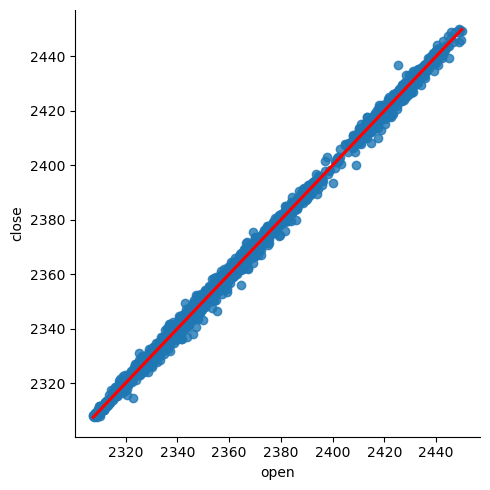

In [11]:
sns.lmplot(x='open', y='close', data=df, ci=None, line_kws={'color': 'red'})

<Axes: >

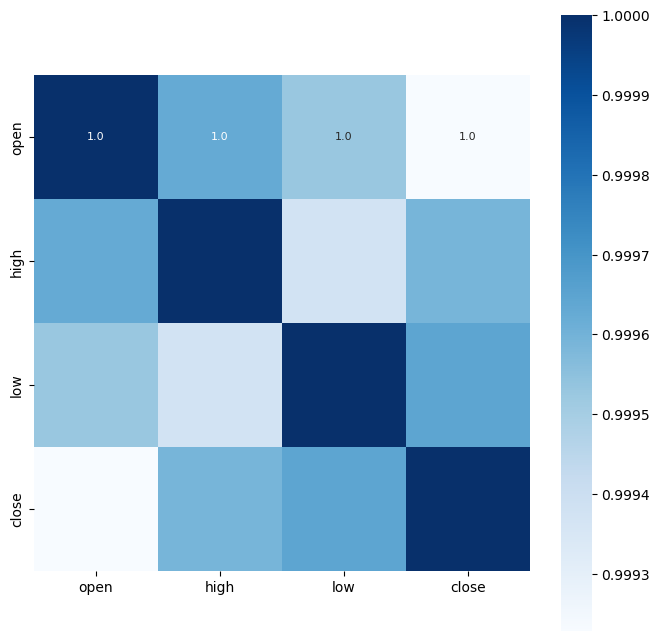

In [12]:
correlation = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 8}, cmap='Blues')


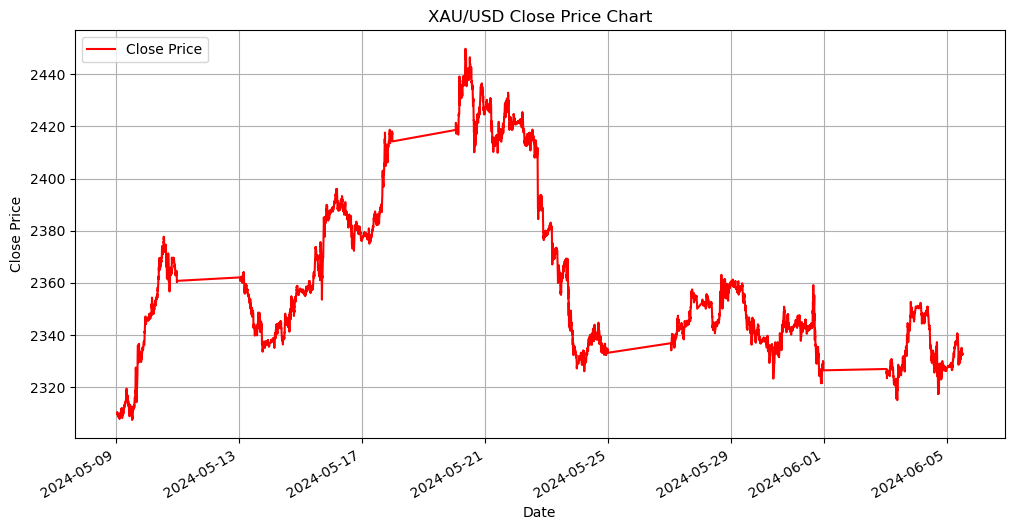

In [14]:
df_plot = df['close'].plot(figsize=(12, 6), 
                           title='XAU/USD Close Price Chart', 
                           grid=True, 
                           color='red', 
                           label='Close Price')
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Close Price')
df_plot.legend(loc='upper left')
plt.show()

In [15]:
df.duplicated().sum()

0

In [16]:
df.isnull().sum().sum()

0

In [17]:
df.head()

,open,high,low,close
date/time,,,,
2024-05-09 01:05:00,2309.55,2310.37,2309.39,2310.16
2024-05-09 01:10:00,2310.01,2310.19,2309.30,2309.63
2024-05-09 01:15:00,2309.63,2310.52,2309.63,2310.33
2024-05-09 01:20:00,2310.38,2310.80,2310.17,2310.33
2024-05-09 01:25:00,2310.37,2310.37,2310.02,2310.09


In [19]:
# Define the split point (e.g., 70% training, 30% testing)
split_point = int(len(df) * 0.7)

# Split the data
train = df[:split_point]
test = df[split_point:]

# Define features and target, excluding 'Close' from features
X_train = train[['open', 'high', 'low']]
y_train = train['close']
X_test = test[['open', 'high', 'low']]
y_test = test['close']


In [20]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [21]:
model.score(X_train,y_train)

0.9997097481790744

In [22]:
model.intercept_

-0.6100344504179702

In [23]:
model.coef_

array([-0.5152186 ,  0.7524691 ,  0.76301919])

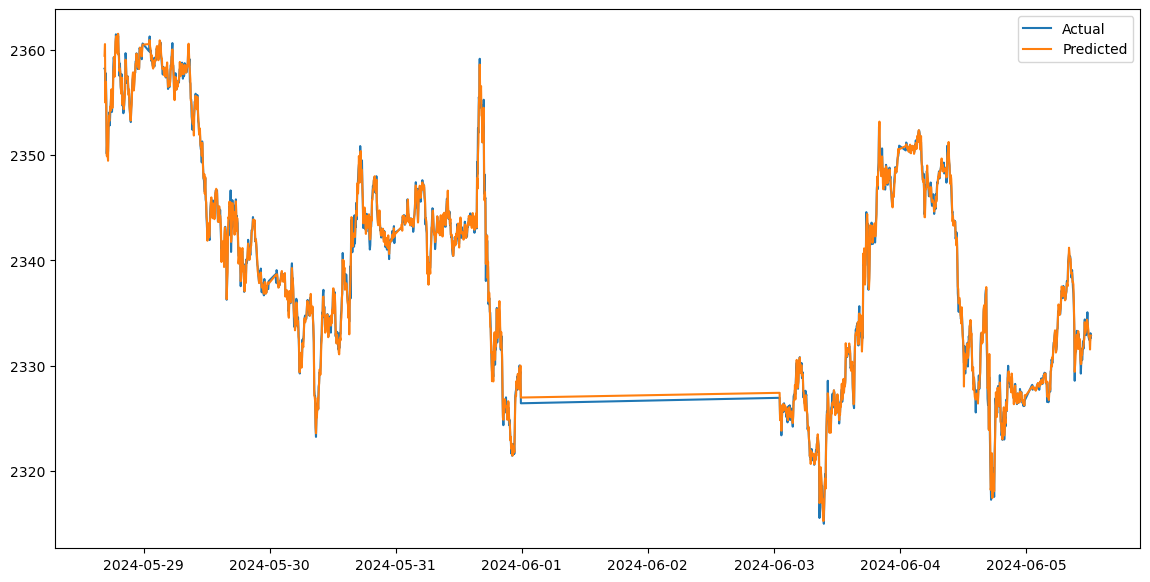

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f"Percentage of variance captured by the model: {r2 * 100:.2f}%")

Mean Absolute Error (MAE): 0.38356611550982683
Mean Squared Error (MSE): 0.27053884425424396
Root Mean Squared Error (RMSE): 0.5201334869571886
R-squared (R2): 0.9975415006578632
Percentage of variance captured by the model: 99.75%


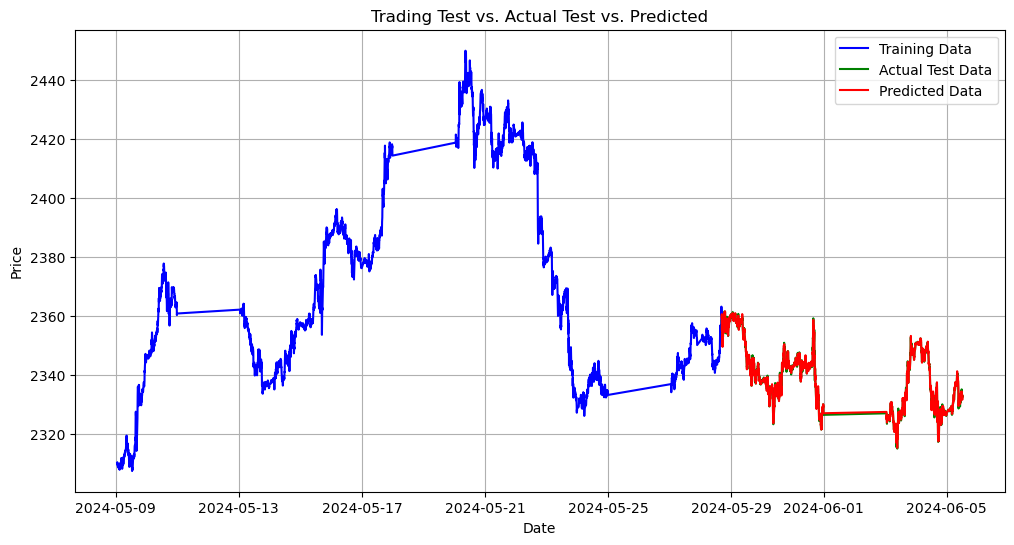

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(train.index, train['close'], label='Training Data', color='blue')

plt.plot(test.index, test['close'], label='Actual Test Data', color='green')

plt.plot(test.index, y_pred, label='Predicted Data', color='red')

plt.grid(True)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Trading Test vs. Actual Test vs. Predicted')
plt.legend()

plt.show()
